<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/master/CodeExamples/TimeSeriesPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# population trends by country through clustering analysis

In [0]:
import pandas as pd
from sklearn import preprocessing
from scipy.spatial import distance_matrix
import pylab as pl
from sklearn import cluster
import numpy as np
pl.rcParams['font.size'] = 15

# Data ingestion

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
cd drive/My\ Drive/MLTSA2020

[Errno 2] No such file or directory: 'drive/My Drive/MLTSA2020'
/content/drive/My Drive/MLTSA2020


In [110]:
!pwd

/content/drive/My Drive/MLTSA2020


In [0]:
#commenting cause already done
#!wget http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel

In [112]:
#reding in simply to see how the data look
pd.read_excel("SP.POP.TOTL?downloadformat=excel", usecols=[0] + 
              list(range(4,100)), skiprows=[1,2]
      ).set_index("Data Source")

,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63
Data Source,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Country Name,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,1966.0,1967.0,1968.0,1969.0,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,1979.0,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
Aruba,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,58386.0,58726.0,59063.0,59440.0,59840.0,60243.0,60528.0,60657.0,60586.0,60366.0,60103.0,59980.0,60096.0,60567.0,61345.0,62201.0,62836.0,63026.0,62644.0,61833.0,61079.0,61032.0,62149.0,64622.0,68235.0,72504.0,76700.0,80324.0,83200.0,85451.0,87277.0,89005.0,90853.0,92898.0,94992.0,97017.0,98737.0,100031.0,100834.0,101222.0,101358.0,101455.0,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
Afghanistan,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,10174836.0,10399926.0,10637063.0,10893776.0,11173642.0,11475445.0,11791215.0,12108963.0,12412950.0,12689160.0,12943093.0,13171306.0,13341198.0,13411056.0,13356511.0,13171673.0,12882528.0,12537730.0,12204292.0,11938208.0,11736179.0,11604534.0,11618005.0,11868877.0,12412308.0,13299017.0,14485546.0,15816603.0,17075727.0,18110657.0,18853437.0,19357126.0,19737765.0,20170844.0,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
Angola,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,5781214.0,5774243.0,5771652.0,5803254.0,5890365.0,6040777.0,6248552.0,6496962.0,6761380.0,7024000.0,7279509.0,7533735.0,7790707.0,8058067.0,8341289.0,8640446.0,8952950.0,9278096.0,9614754.0,9961997.0,10320111.0,10689250.0,11068050.0,11454777.0,11848386.0,12248901.0,12657366.0,13075049.0,13503747.0,13945206.0,14400719.0,14871570.0,15359601.0,15866869.0,16395473.0,16945753.0,17519417.0,18121479.0,18758145.0,19433602.0,20149901.0,20905363.0,21695634.0,22514281.0,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
Albania,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,2022272.0,2081695.0,2135479.0,2187853.0,2243126.0,2296752.0,2350124.0,2404831.0,2458526.0,2513546.0,2566266.0,2617832.0,2671997.0,2726056.0,2784278.0,2843960.0,2904429.0,2964762.0,3022635.0,3083605.0,3142336.0,3227943.0,3286542.0,3266790.0,3247039.0,3227287.0,3207536.0,3187784.0,3168033.0,3148281.0,3128530.0,3108778.0,3089027.0,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,1191000.0,1219000.0,1247000.0,1278000.0,1308000.0,1

In [113]:
#reading in with appropriuate rules. Note the data name. That is BAD! I should give it a meaningful name
datain = pd.read_excel("SP.POP.TOTL?downloadformat=excel", usecols=[0] + 
              list(range(4,100)), skiprows=[1,2]
      ).set_index("Data Source")
datain.columns = datain.iloc[0]
datain.drop("Country Name", inplace=True)
datain

Country Name,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,1966.0,1967.0,1968.0,1969.0,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,1979.0,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
Data Source,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aruba,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,58386.0,58726.0,59063.0,59440.0,59840.0,60243.0,60528.0,60657.0,60586.0,60366.0,60103.0,59980.0,60096.0,60567.0,61345.0,62201.0,62836.0,63026.0,62644.0,61833.0,61079.0,61032.0,62149.0,64622.0,68235.0,72504.0,76700.0,80324.0,83200.0,85451.0,87277.0,89005.0,90853.0,92898.0,94992.0,97017.0,98737.0,100031.0,100834.0,101222.0,101358.0,101455.0,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
Afghanistan,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,10174836.0,10399926.0,10637063.0,10893776.0,11173642.0,11475445.0,11791215.0,12108963.0,12412950.0,12689160.0,12943093.0,13171306.0,13341198.0,13411056.0,13356511.0,13171673.0,12882528.0,12537730.0,12204292.0,11938208.0,11736179.0,11604534.0,11618005.0,11868877.0,12412308.0,13299017.0,14485546.0,15816603.0,17075727.0,18110657.0,18853437.0,19357126.0,19737765.0,20170844.0,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
Angola,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,5781214.0,5774243.0,5771652.0,5803254.0,5890365.0,6040777.0,6248552.0,6496962.0,6761380.0,7024000.0,7279509.0,7533735.0,7790707.0,8058067.0,8341289.0,8640446.0,8952950.0,9278096.0,9614754.0,9961997.0,10320111.0,10689250.0,11068050.0,11454777.0,11848386.0,12248901.0,12657366.0,13075049.0,13503747.0,13945206.0,14400719.0,14871570.0,15359601.0,15866869.0,16395473.0,16945753.0,17519417.0,18121479.0,18758145.0,19433602.0,20149901.0,20905363.0,21695634.0,22514281.0,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
Albania,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,2022272.0,2081695.0,2135479.0,2187853.0,2243126.0,2296752.0,2350124.0,2404831.0,2458526.0,2513546.0,2566266.0,2617832.0,2671997.0,2726056.0,2784278.0,2843960.0,2904429.0,2964762.0,3022635.0,3083605.0,3142336.0,3227943.0,3286542.0,3266790.0,3247039.0,3227287.0,3207536.0,3187784.0,3168033.0,3148281.0,3128530.0,3108778.0,3089027.0,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
Andorra,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,21890.0,23058.0,24276.0,25559.0,26892.0,28232.0,29520.0,30705.0,31777.0,32771.0,33737.0,34818.0,36067.0,37500.0,39114.0,40867.0,42706.0,44600.0,46517.0,48455.0,50434.0,52448.0,54509.0,56671.0,58888.0,60971.0,62677.0,63850.0,64360.0,64327.0,64142.0,64370.0,65390.0,67341.0,70049.0,73182.0,76244.0,78867.0,80993.0,82684.0,83862.0,84463.0,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,1191000.0,1219000.0,1247000.0,1278000.0,1308000.0,1339000.0,1369000.0,1400000.0,1430000.0,1460000.0,1491000.0,1521000.0,1552000.0,1582000.0,1614000.0,1647000.0,1682000.0,1717000.0,1753000.0,1791000.0,1827000.0,1862000.0,1898000.0,1932000.0,1965000.0,1997000.0,2029000.0,2059000.0,20

In [114]:
print("there are {} countries and {} time stamps in the data".
      format(*datain.shape))

there are 264 countries and 60 time stamps in the data


Cleaning the data from NaNs

In [115]:
#cleaned dataset timestamps
datain = datain.dropna(axis=1, how='all')
(datain.isna().sum()>0).sum()

59

In [0]:
datain = datain.dropna(axis=0)

In [117]:
(datain.isna().sum()>0).sum()

0

In [118]:
print("there are {} countries and {} time stamps in the cleaned data".
      format(*datain.shape))

there are 258 countries and 59 time stamps in the cleaned data


In [0]:
# visualizing the raw data. This is NOT a good plot choice, but it tells me that the data is diverse. 

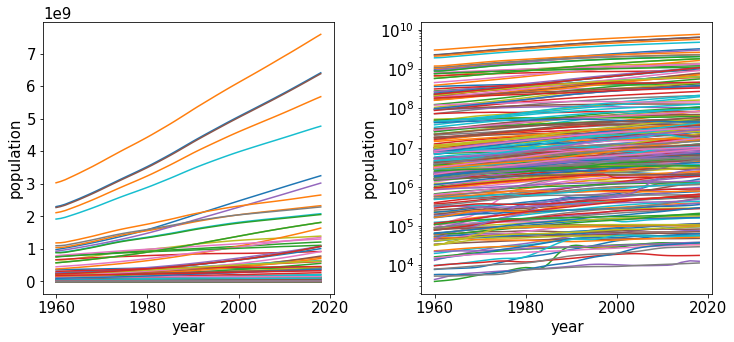

In [120]:
fig, axs = pl.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.3)
ax1 = datain.T.plot(legend=False, ax=axs[0]);
ax1.set_xlabel("year")
ax1.set_ylabel("population");
ax2 = datain.T.plot(legend=False, ax=axs[1], logy=True);
ax2.set_xlabel("year")
ax2.set_ylabel("population");


Figure 1: plot of  population time series since 1960 through 2018 for all countries vith valid time series (no missing data) as sourced from the worldbank dataset (accessed 10/14/2019 http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel) in natural scale on the left and y-log scale on the right. The time series have a different mean  but all show a general increasing trend.

In [0]:
subsetcountries = ['Bulgaria',
 'Bosnia and Herzegovina',
 'Estonia',
 'Georgia',
 'Croatia',
 'Hungary',
 'Lithuania',
 'Latvia',
 'Romania',
 'Ukraine']

In [0]:
datasubset = datain.loc[subsetcountries]

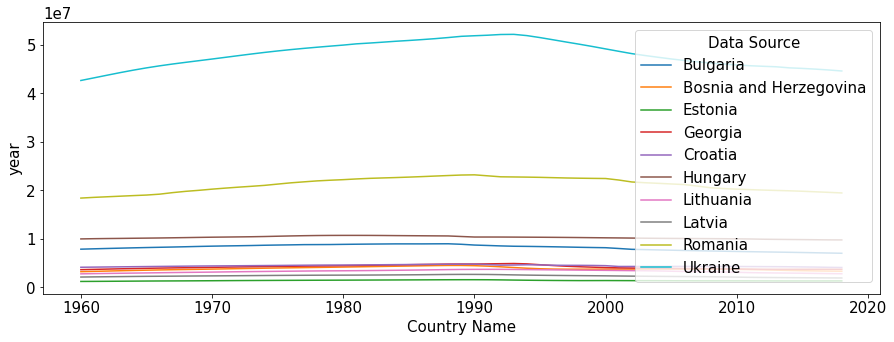

In [123]:
ax = pl.figure(figsize=(15,5)).add_subplot(111)
datasubset.T.plot(ax = ax);
pl.ylabel("population")
pl.ylabel("year");

Figure 2: time series of population by country over time from 1960 throught 2012. Data source : wikipedia (last sourced 04/13/20) . This subset of lightcurve includes only the "eastern-block": 'Bulgaria',
 'Bosnia and Herzegovina',
 'Estonia',
 'Georgia',
 'Croatia',
 'Hungary',
 'Lithuania',
 'Latvia',
 'Romania',
 'Ukraine'.  **As they are these time series do not look similar. But in most cases when we say similar we mean "similar shape" and the absolute value of these time series does not allow us to compare the shape.**

# preprocessing:


**To  work with raw features in time series scale time series along the observation axis (row, axis=1) instead of the feature axis (column, axis=0)**

*These* are time series so *they cannot be whitened*
They should be scaled *along the observation axis* (i.e. row i.e. axis=1) instead of the feature axis (column, axis-0)

In [124]:
datasubsetScaled = preprocessing.scale(datasubset, axis=1)
datasubsetScaled.mean(axis=1).shape, datasubsetScaled.mean(axis=1), datasubsetScaled.std(axis=1)


((10,),
 array([ 3.98927595e-16, -2.25808073e-17, -9.50275640e-16, -1.39248312e-16,
         9.03232291e-17,  1.12904036e-16,  3.87637192e-16, -9.70974713e-16,
         7.15058897e-16,  1.05377101e-15]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [0]:
distance_matrix?

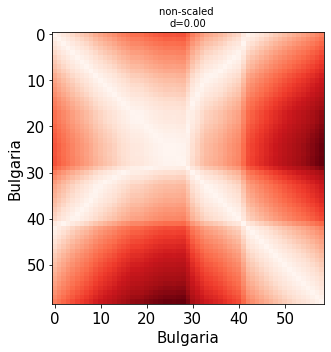

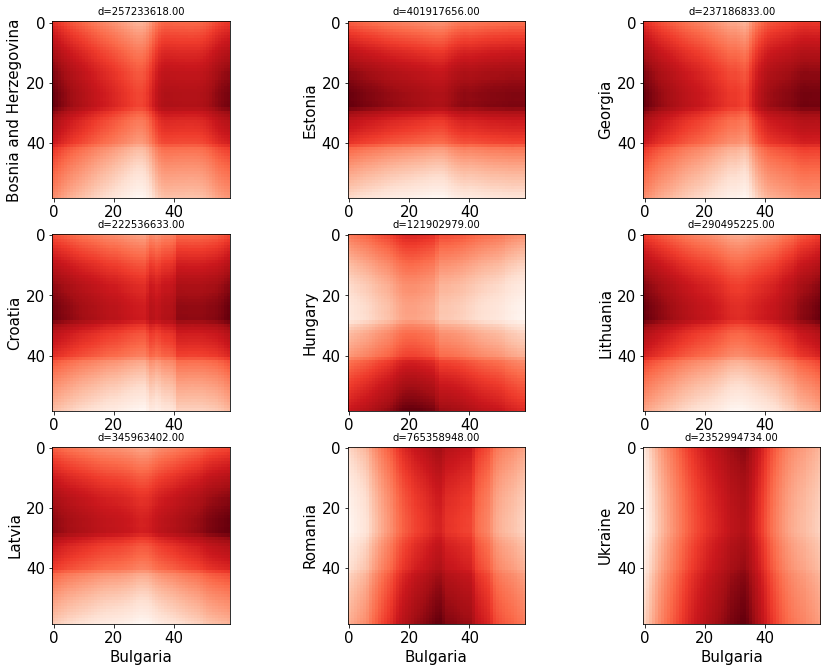

In [126]:
fig = pl.figure(figsize=(5,5))
dm = distance_matrix(np.atleast_2d(datasubset.loc[subsetcountries[0]]).T, 
                        np.atleast_2d(datasubset.loc[subsetcountries[0]]).T)
pl.imshow(dm, cmap='Reds')
pl.ylabel(subsetcountries[0])
pl.xlabel(subsetcountries[0])      
#pl.colorbar(tmp)
pl.title("non-scaled \n" +  
               "d=%.2f"%np.diagonal(dm).sum(), fontsize=10)
fig = pl.figure(figsize=(15,15))
for i,country1 in enumerate(subsetcountries[:1]):
  for j,country2 in enumerate(subsetcountries[1:]):
      ax = fig.add_subplot(4,3,i*3+j+1)
      dm = distance_matrix(np.atleast_2d(datasubset.loc[country1]).T, 
                        np.atleast_2d(datasubset.loc[country2]).T)
      ax.imshow(dm, cmap='Reds')
      pl.ylabel(country2)
      if j > 5:
        pl.xlabel(country1)      
      #pl.colorbar(tmp)
      pl.title("d=%.2f"%np.diagonal(dm).sum(), fontsize=10)
pl.show()
      

Figure 3: distance matrix cor Euclidean distance between the time serie for Bulgaria and each of the other time series. In the first plot (Bulgaria vs Bulgaria) the diagonal is 0. The distance values are very large. 

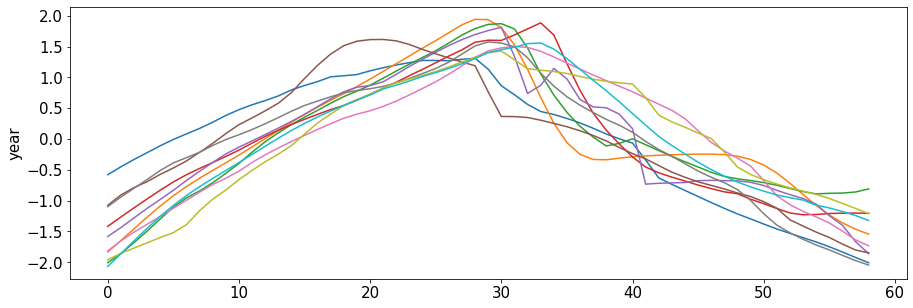

In [127]:
ax = pl.figure(figsize=(15,5)).add_subplot(111)
for i,c in enumerate(subsetcountries):
  ax.plot(datasubsetScaled[i], label=c);
pl.ylabel("population")
pl.ylabel("year");

Figure 4: the same time-series as in Figure 2 but now scaled so that each time series is mean 0 and variance 1

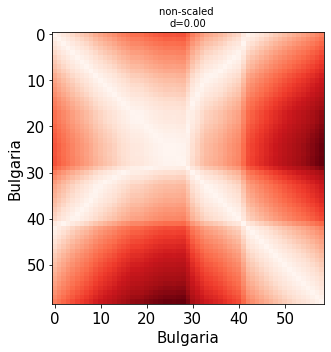

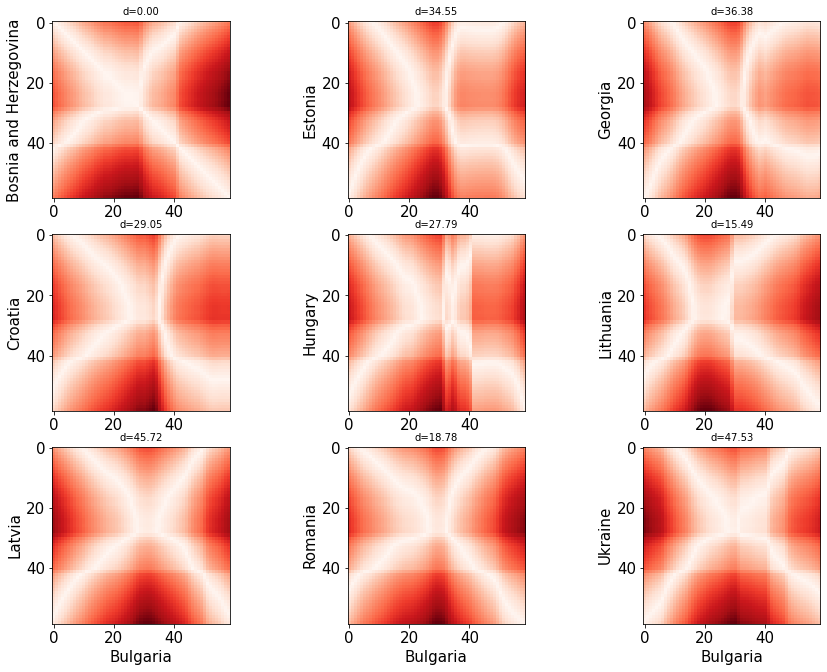

In [131]:
fig = pl.figure(figsize=(5,5))
dm = distance_matrix(np.atleast_2d(datasubsetScaled[0]).T, 
                                 np.atleast_2d(datasubsetScaled[0]).T)
      
pl.imshow(dm, cmap='Reds')
pl.ylabel(subsetcountries[0])
pl.xlabel(subsetcountries[0])      
#pl.colorbar(tmp)
pl.title("non-scaled \n" +  
               "d=%.2f"%np.diagonal(dm).sum(), fontsize=10)
fig = pl.figure(figsize=(15,15))

for i,country1 in enumerate(subsetcountries[:1]):
  for j,country2 in enumerate(subsetcountries[1:]):
      ax = fig.add_subplot(4,3,i*3+j+1)
      dm = distance_matrix(np.atleast_2d(datasubsetScaled[i]).T, 
                                 np.atleast_2d(datasubsetScaled[j]).T)
      ax.imshow(dm, cmap='Reds')
      pl.ylabel(country2)
      if j > 5:
        pl.xlabel(country1)      
      else :
        pl.xlabel("")
      pl.title("d=%.2f"%np.diagonal(dm).sum(), fontsize=10)
pl.show()


Figure 5: distances are now manageably small and they reflect how similar time series are in shape